In [1]:
import pickle
from scipy.stats import pearsonr, spearmanr
import pandas as pd
import numpy as np
import math
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.6)
from matplotlib.colors import LogNorm

# Change here!
fpath = "C:/Users/ys8mz/Box Sync/Predictive Models of College Completion (VCCS)/evaluation_results/truncated_without_demo"
fpath2 = "C:/Users/ys8mz/Box Sync/Predictive Models of College Completion (VCCS)/evaluation_results/truncated_predictors"
output_fpath = "C:/Users/ys8mz/Box Sync/Predictive Models of College Completion (VCCS)/evaluation_results/truncated_without_demo/cleaned_results"

In [20]:
m_dict = {'lr': 'Logit', 'ols': 'OLS',
          'rf': 'RF', 'xgb': 'XGBoost',
          'cox': 'CoxPH', 'rnn': 'RNN'}
pred_dict = {}
for m in ['lr','ols','cox','rf','xgb']:
    pred_dict[m_dict[m]] = list(pickle.load(open(fpath + "/y_test_pred_{}.p".format(m), 'rb')))
pred_dict['RNN'] = list(e[0] for e in pickle.load(open("C:/Users/ys8mz/Box Sync/Predictive Models of College Completion (VCCS)/intermediate_files/y_test_pred_rnn_no_demo.p", "rb")))
pred_dict_2 = {}
base_pred = pd.read_csv(fpath2 + "/cleaned_results/all_pred_scores.csv")
for m in base_pred.columns.values[1:]:
    pred_dict_2[m] = list(base_pred[m])
pred_dict_2['CoxPH'] = list(pickle.load(open("C:/Users/ys8mz/Box Sync/Predictive Models of College Completion (VCCS)/intermediate_files/y_test_pred_cox.p", "rb")))
pred_dict_2['RNN'] = list(pickle.load(open("C:/Users/ys8mz/Box Sync/Predictive Models of College Completion (VCCS)/intermediate_files/y_test_pred_rnn.p", "rb")))

#### Generate Figure A21 of the paper

In [21]:
pred_pctile_dict = {}
for m in ['OLS','Logit','CoxPH','RF','XGBoost', "RNN"]:
    pred_pctile_dict[m] = \
    pd.cut(pred_dict[m], [-math.inf] + list(np.quantile(pred_dict[m], q=np.linspace(0.01,0.99,99))) + [math.inf],
           labels = range(100,0,-1)).astype(int)
pred_pctile_dict_2 = {}
for m in ['OLS','Logit','CoxPH','RF','XGBoost', 'RNN']:
    pred_pctile_dict_2[m] = \
    pd.cut(pred_dict_2[m], [-math.inf] + list(np.quantile(pred_dict_2[m], q=np.linspace(0.01,0.99,99))) + [math.inf],
           labels = range(100,0,-1)).astype(int)

In [22]:
m_list = ['OLS','Logit','CoxPH','RF','XGBoost', "RNN"]
r = []
for i1,m in enumerate(m_list):
    g1 = pred_pctile_dict_2[m]
    g2 = pred_pctile_dict[m]
    g_diff = np.abs(np.array(g1) - np.array(g2))
    r.append((m,
              sum(np.array(g_diff>=0) & np.array(g_diff<=5))/len(g_diff),
              sum(np.array(g_diff>5) & np.array(g_diff<=10))/len(g_diff), 
              sum(np.array(g_diff>10) & np.array(g_diff<=15))/len(g_diff),
              sum(np.array(g_diff>15) & np.array(g_diff<=20))/len(g_diff),
              sum(g_diff>20)/len(g_diff)))
r_df = pd.DataFrame(r, columns=['Model', 'Move_0-5_percentiles',
                                'Move_6-10_percentiles', 'Move_11-15_percentiles', 
                                'Move_16-20_percentiles', 'Move_21_or_more_percentiles'])
r_df = r_df.round(4)
r_df.to_csv(output_fpath + "/pred_score_comparison/updated/percentile_change_1_new.csv", index=False)
print(r_df)

     Model  Move_0-5_percentiles  Move_6-10_percentiles  \
0      OLS                0.9280                 0.0673   
1    Logit                0.9471                 0.0506   
2    CoxPH                0.8773                 0.0918   
3       RF                0.9311                 0.0615   
4  XGBoost                0.8128                 0.1509   
5      RNN                0.6866                 0.2123   

   Move_11-15_percentiles  Move_16-20_percentiles  Move_21_or_more_percentiles  
0                  0.0044                  0.0003                       0.0000  
1                  0.0023                  0.0000                       0.0000  
2                  0.0185                  0.0062                       0.0062  
3                  0.0063                  0.0011                       0.0001  
4                  0.0306                  0.0047                       0.0009  
5                  0.0657                  0.0219                       0.0136  


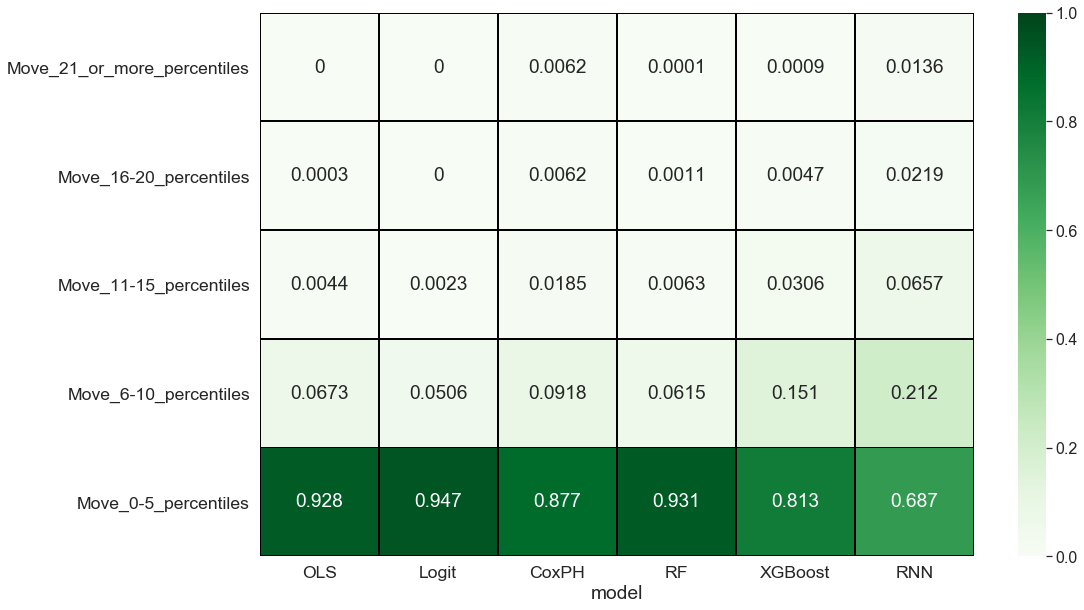

In [23]:
col_labels = list(r_df.iloc[:,0])
row_labels = ['Move_21_or_more_percentiles', 'Move_16-20_percentiles', 'Move_11-15_percentiles', 
              'Move_6-10_percentiles', 'Move_0-5_percentiles']
new_r_df = pd.DataFrame(r_df.iloc[:,1:].get_values().T[range(4,-1,-1),:], columns=col_labels, index=row_labels)
vmin = r_df.iloc[:,1:].get_values().min().min()
vmax = r_df.iloc[:,1:].get_values().max().max()
l = vmax - vmin
plt.figure(figsize=(16,10))
g = sns.heatmap(new_r_df,annot=True,fmt=".3g",cmap="Greens",vmin=max(0,vmin-0.2*l),vmax=min(1,vmax+0.2*l),
                linewidths=1, linecolor='black')
g.set_yticklabels(g.get_yticklabels(), rotation = 0)
cbar = g.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)
plt.xlabel("model")
plt.savefig(output_fpath+"/pred_score_comparison/updated/percentile_change_1_heatmap_new.png", bbox_inches="tight")
plt.show()

#### Generate Figure A22 of the paper

In [24]:
top_ind = 0
stuid_list = {}
for q in [0.1,0.3,0.5]:
    for i,m in enumerate(m_list):
        g = [(e1,e2) for e1,e2 in zip(base_pred.iloc[:,0], pred_dict_2[m])]
        l = len(pred_dict_2[m])
        l1 = int(round(l*(q-0.1)))
        l2 = int(round(l*q))
        if top_ind == 0:
            new_t = sorted(g, key=lambda x:x[1])
        else:
            new_t = sorted(g, key=lambda x:-x[1])
        stuid = [e[0] for e in new_t[l1:l2]]
        stuid_list[(m,q)] = stuid[:]
        # common = np.zeros((4,4))

In [25]:
top_ind = 0
stuid_list_2 = {}
for q in [0.1,0.3,0.5]:
    for i,m in enumerate(m_list):
        g = [(e1,e2) for e1,e2 in zip(base_pred.iloc[:,0], pred_dict[m])]
        l = len(pred_dict[m])
        l1 = int(round(l*(q-0.1)))
        l2 = int(round(l*q))
        if top_ind == 0:
            new_t = sorted(g, key=lambda x:x[1])
        else:
            new_t = sorted(g, key=lambda x:-x[1])
        stuid = [e[0] for e in new_t[l1:l2]]
        stuid_list_2[(m,q)] = stuid[:]

In [26]:
new_rr = []
for q in [0.1,0.3,0.5]:
    for m in m_list:
        new_rr.append((m,q,round(len(np.intersect1d(stuid_list[(m,q)], stuid_list_2[(m,q)]))/len(stuid_list[(m,q)]),4)))
new_rr

[('OLS', 0.1, 0.8925),
 ('Logit', 0.1, 0.9194),
 ('CoxPH', 0.1, 0.881),
 ('RF', 0.1, 0.8457),
 ('XGBoost', 0.1, 0.7569),
 ('RNN', 0.1, 0.6893),
 ('OLS', 0.3, 0.6992),
 ('Logit', 0.3, 0.7665),
 ('CoxPH', 0.3, 0.73),
 ('RF', 0.3, 0.7273),
 ('XGBoost', 0.3, 0.4835),
 ('RNN', 0.3, 0.4174),
 ('OLS', 0.5, 0.6987),
 ('Logit', 0.5, 0.7292),
 ('CoxPH', 0.5, 0.6929),
 ('RF', 0.5, 0.756),
 ('XGBoost', 0.5, 0.6739),
 ('RNN', 0.5, 0.5396)]

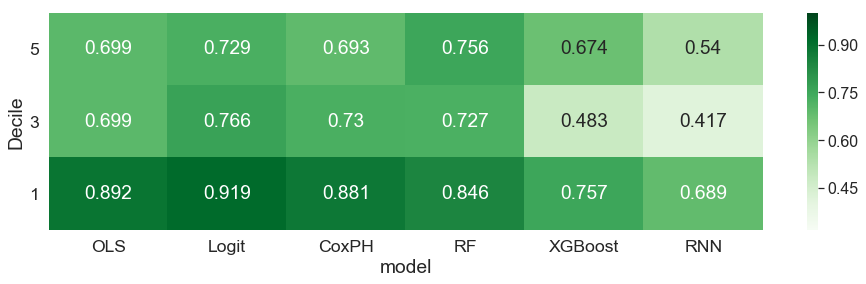

In [27]:
rr_df = pd.DataFrame(new_rr,columns=['model','5th_6th_quantile','overlapping'])
# rr_df.to_csv(output_fpath + "/pred_score_comparison/updated/5th_6th_quantile_overlapping.csv", index=False)
new_rr_df = rr_df.pivot(index='5th_6th_quantile', columns='model', values='overlapping').loc[:,m_list].sort_index(ascending=False)
new_rr_df.index = [int(e) for e in new_rr_df.index*10]
new_rr_df.index.name = "Decile"
vmin = rr_df.iloc[:,2:].get_values().min().min()
vmax = rr_df.iloc[:,2:].get_values().max().max()
l = vmax - vmin
plt.figure(figsize=(16,4))
g = sns.heatmap(new_rr_df,annot=True,fmt=".3g",cmap="Greens",vmin=max(0,vmin-0.2*l),vmax=min(1,vmax+0.2*l))
g.set_yticklabels(g.get_yticklabels(), rotation = 0)
cbar = g.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)
plt.savefig(output_fpath+"/pred_score_comparison/updated/5th_6th_quantile_overlapping_heatmap.png", bbox_inches='tight')
plt.show()

#### Share of top 20% important features in common across within model type, base models versus models excluding demographic predictors -- used to generate Appendix Table A3 of the paper

In [4]:
df = pd.read_stata("C:/Users/ys8mz/Box Sync/Predictive Models of College Completion (VCCS)/intermediate_files/full_data_truncated.dta")
demo_predictors = ["age_entry", "male", "white", "afam", "hisp", "other", "pell_0_ind", "pell_1_ind"] + \
["pell_0_" + s1 + str(s2) for s1 in ["fa","sp","su"] for s2 in range(1,7)] + \
["pell_1_" + s1 + str(s2) for s1 in ["fa","sp","su"] for s2 in range(1,7)] + \
["phe_" + str(i) for i in range(1,8)]
demo_predictors = set(demo_predictors)
predictors = [p for p in list(df.columns)[10:] if p not in demo_predictors]
len(predictors)
m_list = ['OLS','Logit','RF','XGBoost']

In [6]:
import numpy as np
n = 66
rrr_list = []
for mn in m_list:
    d2 = pd.read_csv(fpath2 + "/cleaned_results/feature_ranking/{}_feature_ranking.csv".format(mn)).predictor_name.iloc[:n]
    d2 = np.intersect1d(d2, predictors)
    d1 = pd.read_csv(output_fpath + "/feature_ranking/{}_feature_ranking.csv".format(mn)).predictor_name.iloc[:len(d2)]
    rrr_list.append((mn, n-len(d2), round(len(np.intersect1d(d1,d2))/n,4)))
pd.DataFrame(rrr_list, columns=['model', 'dropped_predictors', 'proportion_overlapped']).to_csv(output_fpath+"/feature_ranking/top_20pct_overlapping_new.csv", index=False)
rrr_list

[('OLS', 1, 0.9394),
 ('Logit', 1, 0.9242),
 ('RF', 1, 0.9394),
 ('XGBoost', 3, 0.9242)]